In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')  # Add at top of script

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset_path = Path('../data/dataset')
model_path = Path('../data/model/')

for p in [dataset_path, model_path]:
    print(f'checking {p}')
    p.mkdir(exist_ok=True, parents=True)

checking ../data/dataset
checking ../data/model


In [3]:
dataset = dataset_path / 'ngt_keypoint.csv'
model_save_path = model_path / 'keypoint_classifier.keras'
tflite_save_path = model_path / 'keypoint_classifier.tflite'
# model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
# tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 26

# Dataset reading

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
# Cell 1: Improved train/validation split with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_dataset, y_dataset, 
    train_size=0.70, 
    random_state=RANDOM_SEED,
    stratify=y_dataset  # Balance classes
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    train_size=0.50,
    random_state=RANDOM_SEED,
    stratify=y_temp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 36822, Val: 7891, Test: 7891


# Model building

In [8]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((21 * 2, )),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(128, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(64, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(32, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
# ])


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('mish'),  # Keep mish
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('mish'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('mish'),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2026-01-20 15:29:34.573111: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2026-01-20 15:29:34.573133: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-20 15:29:34.573142: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-20 15:29:34.573396: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-20 15:29:34.573598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Cell 3: Better callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    str(model_save_path), 
    verbose=1, 
    save_weights_only=False,
    save_best_only=True,  # Only save best
    monitor='val_loss'
)

es_callback = tf.keras.callbacks.EarlyStopping(
    patience=30,  # Increased patience
    verbose=1,
    restore_best_weights=True,
    monitor='val_loss'
)

# Add learning rate reduction
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

In [11]:
# Cell 4: Optimizer with gradient clipping
import platform

is_apple_silicon = (
    platform.system() == 'Darwin' and 
    platform.processor() == 'arm'
)

if is_apple_silicon:
    print("Detected Apple Silicon - using legacy optimizer")
    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=0.001,
        clipnorm=1.0  # Clip gradients
    )
else:
    print("Using standard optimizer")
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        clipnorm=1.0
    )

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Detected Apple Silicon - using legacy optimizer


# Model training

In [12]:
# model.fit(
#     X_train,
#     y_train,
#     epochs=1000,
#     batch_size=128,
#     validation_data=(X_test, y_test),
#     callbacks=[cp_callback, es_callback]
# )

In [13]:
# Cell 5: Train with validation data
history = model.fit(
    X_train,
    y_train,
    epochs=500,  # Reduced from 1000
    batch_size=128,
    validation_data=(X_val, y_val),  # Use validation set
    callbacks=[cp_callback, es_callback, lr_callback],
    verbose=1
)

Epoch 1/500


2026-01-20 15:29:35.658364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


288/288 [==============================] - ETA: 0s - loss: 1.3613 - accuracy: 0.6913
Epoch 1: val_loss improved from inf to 0.78804, saving model to ../data/model/keypoint_classifier.keras
288/288 [==============================] - 7s 18ms/step - loss: 1.3613 - accuracy: 0.6913 - val_loss: 0.7880 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 2/500
288/288 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8970
Epoch 2: val_loss improved from 0.78804 to 0.21696, saving model to ../data/model/keypoint_classifier.keras
288/288 [==============================] - 5s 16ms/step - loss: 0.4507 - accuracy: 0.8970 - val_loss: 0.2170 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 3/500
286/288 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.9321
Epoch 3: val_loss improved from 0.21696 to 0.14245, saving model to ../data/model/keypoint_classifier.keras
288/288 [==============================] - 5s 17ms/step - loss: 0.2659 - accuracy: 0.9324 - val_loss: 0.1424 - 

In [14]:
# Then calculate F1 on test set
from sklearn.metrics import classification_report, f1_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Overall F1 scores
f1_micro = f1_score(y_test, y_pred_classes, average='micro')
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
f1_weighted = f1_score(y_test, y_pred_classes, average='weighted')

print(f"F1 Micro: {f1_micro:.4f}")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

# Per-class report
print("\nPer-class metrics:")
print(classification_report(y_test, y_pred_classes))

247/247 [==============================] - 1s 4ms/step
F1 Micro: 0.9944
F1 Macro: 0.9926
F1 Weighted: 0.9944

Per-class metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       0.99      0.99      0.99       192
           2       1.00      0.99      1.00       465
           3       1.00      1.00      1.00       341
           4       1.00      1.00      1.00       351
           5       0.99      0.99      0.99       154
           6       1.00      1.00      1.00       342
           7       1.00      1.00      1.00       482
           8       1.00      0.99      1.00       539
           9       0.99      1.00      1.00       412
          10       1.00      1.00      1.00       280
          11       0.96      0.97      0.96       213
          12       1.00      1.00      1.00       287
          13       1.00      1.00      1.00       295
          14       1.00      1.00      1.00       287
      

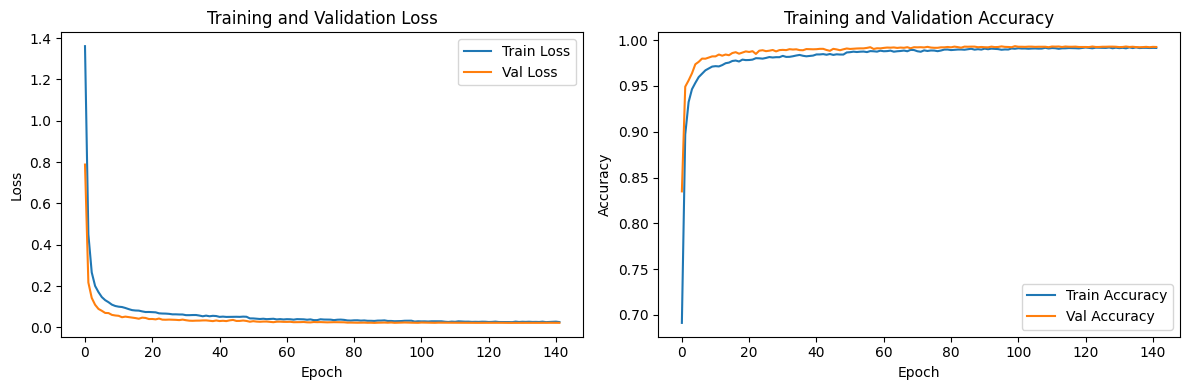

In [15]:
# Cell 6: Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')

# Accuracy
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

62/62 [==============================] - 0s 6ms/step - loss: 0.0212 - accuracy: 0.9944


In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 202ms/step
[3.1480550e-12 1.0509427e-08 3.1008770e-07 1.6510792e-13 2.2579136e-11
 1.2194153e-11 1.6871963e-05 4.5641917e-11 1.2351027e-08 3.2955281e-09
 4.1595160e-12 5.3956843e-08 3.5023484e-13 7.6223524e-12 9.9983740e-01
 3.0087316e-10 2.0171834e-10 1.4341989e-04 1.1363702e-08 5.9406735e-17
 1.9174641e-07 8.0678866e-08 4.5896338e-17 6.7202912e-08 1.3901016e-09
 1.3680772e-06]
14


# Confusion matrix

247/247 [==============================] - 1s 4ms/step


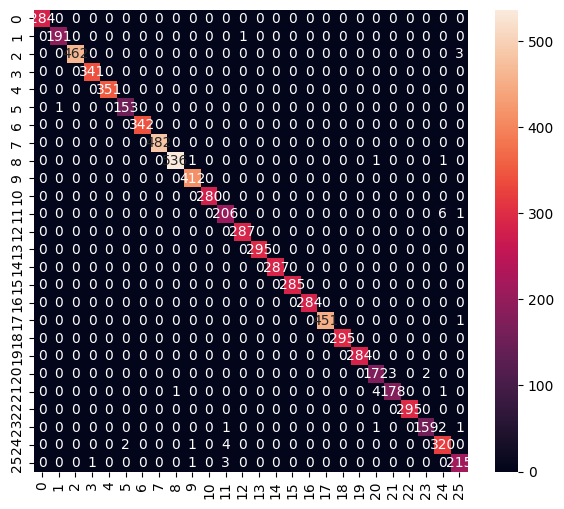

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       284
           1       0.99      0.99      0.99       192
           2       1.00      0.99      1.00       465
           3       1.00      1.00      1.00       341
           4       1.00      1.00      1.00       351
           5       0.99      0.99      0.99       154
           6       1.00      1.00      1.00       342
           7       1.00      1.00      1.00       482
           8       1.00      0.99      1.00       539
           9       0.99      1.00      1.00       412
          10       1.00      1.00      1.00       280
          11       0.96      0.97      0.96       213
          12       1.00      1.00      1.00       287
          13       1.00      1.00      1.00       295
          14       1.00      1.00      1.00       287
          15       1.00      1.00      1.00       285
          16       1.00      1.00      1.00       284
     

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [20]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [21]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/0_/lqcldlm13916lgsd64b4bvx00000gn/T/tmpxeb10uw8/assets


INFO:tensorflow:Assets written to: /var/folders/0_/lqcldlm13916lgsd64b4bvx00000gn/T/tmpxeb10uw8/assets
2026-01-20 15:47:48.240055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2026-01-20 15:47:48.240197: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2026-01-20 15:47:48.244122: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/0_/lqcldlm13916lgsd64b4bvx00000gn/T/tmpxeb10uw8
2026-01-20 15:47:48.245244: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2026-01-20 15:47:48.245251: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/0_/lqcldlm13916lgsd64b4bvx00000gn/T/tmpxeb10uw8
2026-01-20 15:47:48.248714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2026-01-20 15:47:48.249554: I tensorflow/cc/saved_model/load

25576

# Inference test

In [22]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_save_path))
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [23]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [24]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [25]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 223 μs, sys: 106 μs, total: 329 μs
Wall time: 277 μs


In [26]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.4186247e-12 1.4794775e-08 2.8726916e-07 3.0587045e-13 3.2124452e-11
 1.0030910e-11 1.6821426e-05 2.3146773e-10 1.7049839e-08 7.7135134e-09
 1.1890096e-11 9.9572745e-08 7.8434004e-13 4.5729757e-12 9.9968147e-01
 2.5452954e-10 3.0146158e-10 2.9829721e-04 1.3375097e-08 7.5296842e-17
 3.2303595e-07 7.9128569e-08 2.4636202e-16 5.4485028e-08 2.0188713e-09
 2.5150641e-06]
14


In [27]:
# Load the full alphabet labels first
with open('../data/dataset/keypoint_classifier_label.csv', 'r', encoding='utf-8-sig') as f:
    labels = [row[0] for row in csv.reader(f)]

# These are the letters WITHOUT confusion issues
GOOD_LETTERS = ['B', 'C', 'F', 'I', 'L', 'U', 'V', 'X', 'Y', 'Z']

# Check original dataset for these letters
original_counts = {}
with open('../data/dataset/asl_keypoint.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if row:
            label_idx = int(row[0])
            letter = labels[label_idx]
            if letter in GOOD_LETTERS:
                original_counts[letter] = original_counts.get(letter, 0) + 1

print("Counts for GOOD letters in original dataset:")
for letter in GOOD_LETTERS:
    print(f"{letter}: {original_counts.get(letter, 0)}")
    

Counts for GOOD letters in original dataset:
B: 1281
C: 578
F: 1024
I: 1021
L: 1417
U: 1182
V: 1227
X: 1094
Y: 2179
Z: 1464
